# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
# azdias
print('Shape: ' + str(azdias.shape))
print('First few rows:')
azdias.head()

Shape: (891221, 85)
First few rows:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# feat_info
print('Shape: ' + str(feat_info.shape))
print('First few rows:')
feat_info.head()

Shape: (85, 4)
First few rows:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

## loop through all the features to replace the (according to feat_info) missing values with NaN
for feat in azdias.columns:
    
    ## create missing_feat holding a list with the values to be replaced by NaN
    missing_feat = feat_info.loc[feat_info['attribute'] == feat, 'missing_or_unknown'].values[0]
    missing_feat = missing_feat.strip('[').strip(']').split(',')
    
    ## loop through each missing_feat element and replace the feat-th column with NaN
    for val in range(len(missing_feat)):
        
        ## convert val to numeric in case it is convertable
        val_element = pd.to_numeric(missing_feat[val], errors = 'ignore')
        
        ## actual replacement to NaN
        azdias[feat] = azdias[feat].replace(val_element, np.NaN)
        
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

## calculate share of missings per feature and arrange them descending
missing_feat = (azdias.isnull().sum(axis=0) / azdias.shape[0]).sort_values(ascending=False) * 100
missing_feat = round(missing_feat, 2)

## see top 20 features with highest shares of missings
print(missing_feat[0:20])

TITEL_KZ          99.76
AGER_TYP          76.96
KK_KUNDENTYP      65.60
KBA05_BAUMAX      53.47
GEBURTSJAHR       44.02
ALTER_HH          34.81
REGIOTYP          17.74
KKK               17.74
W_KEIT_KIND_HH    16.61
KBA05_ANTG4       14.96
KBA05_GBZ         14.96
MOBI_REGIO        14.96
KBA05_ANTG1       14.96
KBA05_ANTG2       14.96
KBA05_ANTG3       14.96
PLZ8_GBZ          13.07
PLZ8_HHZ          13.07
PLZ8_BAUMAX       13.07
PLZ8_ANTG4        13.07
PLZ8_ANTG1        13.07
dtype: float64


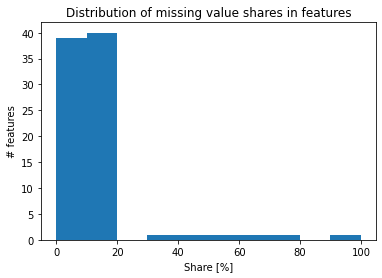

In [8]:
## plot histogram
plt.hist(missing_feat)
plt.xlabel('Share [%]')
plt.ylabel('# features')
plt.title('Distribution of missing value shares in features')
plt.show()

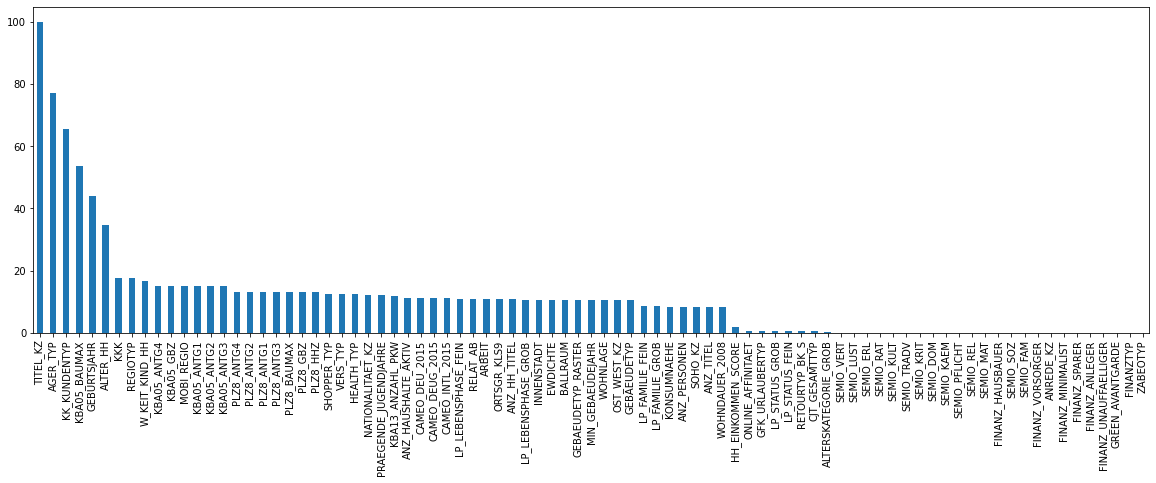

In [9]:
# Investigate patterns in the amount of missing data in each column.

## plot features to see visually, where to cut
missing_feat.sort_values(ascending=False).plot.bar(figsize=(20, 6));

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

## Between the sixth (ALTER_HH) and two seventh (REGIOTYP & KKK) feature is an "elbow".
## It is justifiable to proceed with features having less than 30% of missings only.
## Therefore, I will drop the six features having a share of missing > 30%.

print('Features with share of missings > 30%:')
features_to_drop = missing_feat[missing_feat > 30].index
print(features_to_drop)

print('\nShape before drop: ' + str(azdias.shape))
azdias.drop(features_to_drop, axis=1, inplace=True)
print('Shape after drop: ' + str(azdias.shape))

Features with share of missings > 30%:
Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

Shape before drop: (891221, 85)
Shape after drop: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

*As we can see in the bar chart above there there is kind of an "elbow" between the sixth (ALTER_HH) and two seventh (REGIOTYP & KKK) feature. Imputation can solve a lot, but if the ratio of missings is too high (let's say more than 30%), it is justifiable to proceed without them. Otherwise the quality of the analysis might suffer. From here we will continue with 79 features which is still quite a lot.*

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?

## calculate share of missings per row and arrange them descending
missing_row = azdias.isnull().sum(axis=1)
missing_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

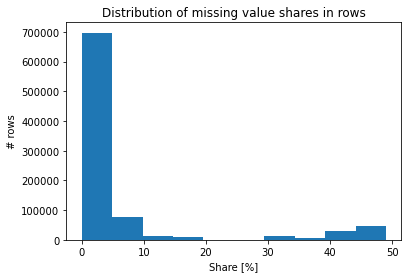

In [12]:
## plot histogram
plt.hist(missing_row)
plt.xlabel('Share [%]')
plt.ylabel('# rows')
plt.title('Distribution of missing value shares in rows')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

## choose again 20% as threshold
missing_below_20 = azdias[azdias.isnull().sum(axis=1) < 20]
missing_above_20 = azdias[azdias.isnull().sum(axis=1) >= 20]

print('# rows < 20:  ' + str(len(missing_below_20)))
print('# rows >= 20: ' + str(len(missing_above_20)))
print(str(round(len(missing_above_20) / azdias.shape[0] * 100, 2)) + '% of rows contain at least 20% of missings.')

# rows < 20:  797077
# rows >= 20: 94144
10.56% of rows contain at least 20% of missings.


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

## create plot function for comparing distributions of subsets
def comparison_plot(features):
    
    ## loop through features
    for feat in features:
        
        ## initialize plot
        fig = plt.figure(figsize=(12, 3))
        
        ## plot number missings >= 20%
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.title.set_text('# missings >= 20%')
        sns.countplot(missing_above_20[feat])
        
        ## plot number missings < 20%
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.title.set_text('# missings < 20%')
        sns.countplot(missing_below_20[feat])
        
        ## plot
        plt.show()

In [15]:
## check out the last five features in the missing_feat series
print(missing_feat.tail(5))

SEMIO_DOM        0.0
SEMIO_KAEM       0.0
SEMIO_PFLICHT    0.0
SEMIO_TRADV      0.0
ZABEOTYP         0.0
dtype: float64


C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


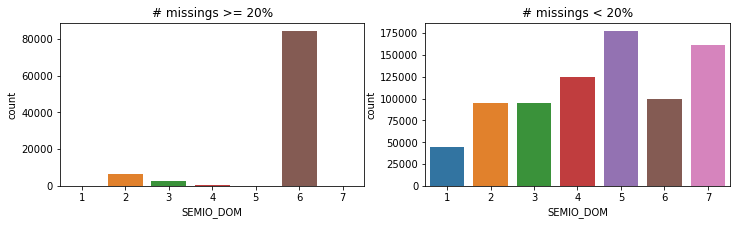

C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


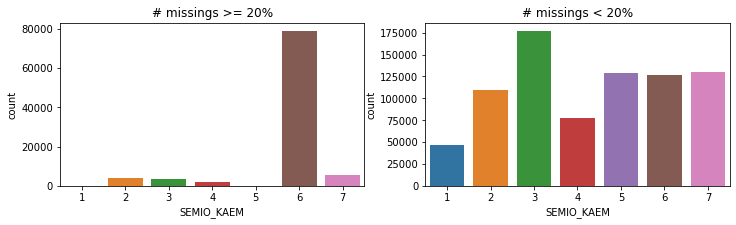

C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


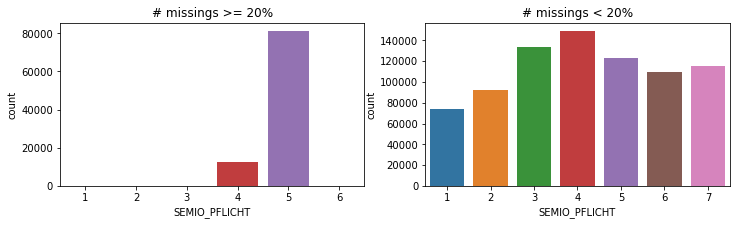

C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


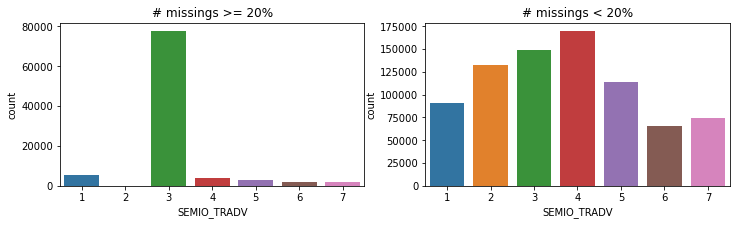

C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rutis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


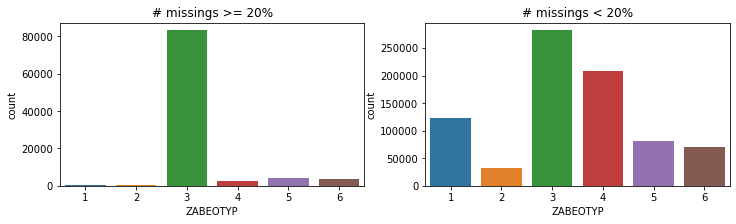

In [16]:
## plot these features using the function comparison_plot
comparison_plot(missing_feat.tail(5).index)

In [17]:
## keep rows with share of missings of less than 0%
azdias = missing_below_20
print(azdias.shape)

(797077, 79)


#### Discussion 1.1.3: Assess Missing Data in Each Row

*10.56% of the rows contain at least 20% of missings. Additionally we discover in the histogram that the 20%-mark is a good threshold for the two subsets.*

*Taking five features with no missing values and compare the distributions between the two subsets we see, that these rows are not similar at all (see barplots right above). Having seen that, I decided to remove the rows having a share of missings of at least 20%.*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
print(feat_info)

               attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]


In [19]:
# How many features are there of each data type?

## first remove attributes from feat_info that we removed before due to number of missings
feat_info = feat_info[~feat_info.attribute.isin(features_to_drop)]

## see counts of each type
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

## get categorical features
cat_feat = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values

## get number of categories within each of the categorical features
azdias[cat_feat].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [21]:
## Check the contents of the categorical features
print("Unique values in each of the categorical features:\n")
for feat in azdias[cat_feat]:
    print(feat + ': ' + str(azdias[feat].unique()))

Unique values in each of the categorical features:

ANREDE_KZ: [2 1]
CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP: [1 6 5 2 4 3]
GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE: [0 1]
LP_FAMILIE_FEIN: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB: [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ: [ 1.  3.  2. nan]
SHOPPER_TYP: [ 3.  2.  1.  0. nan]
SOHO_KZ: [1. 0.]
VERS_TYP: [ 2.  1. nan]
ZABEOTYP: [5 3 4 1 6 2]
GEBAEUDETYP: [8. 1. 3. 2. 6. 4. 5.]
OST_WEST_KZ: ['W' 'O']
CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.

## initialize lists to save according features
feat_bin_num = []
feat_bin_str = []
feat_multi = []

## loop to fill the lists
for feat in cat_feat:
    if azdias[feat].nunique() == 2:
        if feat == 'OST_WEST_KZ':
            feat_bin_str.append(feat)
        else:
            feat_bin_num.append(feat)
    else:
        feat_multi.append(feat)

In [23]:
## check the features
print(feat_bin_str)
print(feat_bin_num)
print(feat_multi)

['OST_WEST_KZ']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [24]:
## convert binary non-numeric features (only OST_WEST_KZ) to binary manually
azdias['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)

# convert binary numeric features (only OST_WEST_KZ) to binary manually that are not zero-one coded yet
azdias['ANREDE_KZ'].replace({2: 0, 1: 1}, inplace=True)
azdias['SOHO_KZ'].replace({0.0: 0, 1.0: 1}, inplace=True)
azdias['VERS_TYP'].replace({1.0: 0, 2.0: 1}, inplace=True)

In [25]:
## convert multi-level features to binary (one-hot-encoding)

## first remove CAMEO_DEU_2015, since it has too many categories
feat_multi.remove('CAMEO_DEU_2015')
azdias.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

## create dummies for the rest
for feat in feat_multi:
    
    ## get all non-missing values
    tmp = azdias[feat][azdias[feat].notnull()]
    
    ## create dummies
    dummies = pd.get_dummies(tmp, prefix=feat)
    
    ## join them to azdias
    azdias = azdias.join(dummies)
    
    ## remove original rows that are dummies now
    azdias.drop([feat], axis=1, inplace=True)

In [26]:
azdias.shape

(797077, 150)

#### Discussion 1.2.1: Re-Encode Categorical Features

*There is one feature (OST_WEST_KZ) that is a binary but non-numeric feature. This I converted to a zero-one feature manually. Then there are three binary binary numeric features, that are not zero-one coded and integers yet. These I converted also manually. For the rest of the categorical features (the multi-levels), I did a one-hot-encoding, except for the CAMEO_DEU_2015 feature which I removed completely due to its huge amount of categories.*

*We end up with the azdias dataframe having 150 features.*

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
## get mixed features
mix_feat = feat_info.loc[feat_info['type'] == 'mixed', 'attribute'].values

## get number of categories within each of the categorical features
azdias[mix_feat].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

1.18. PRAEGENDE_JUGENDJAHRE (from Data_Dictionary.md)

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [29]:
## MOVEMENT

## according to upper description, get categories of avantgarde and mainstream from PRAEGENDE_JUGENDJAHRE
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
mainstream = [1, 3, 5, 8, 10, 12, 14]

## create function that gives back 1, if it's mainstream and 0, if it's avantgarde
def to_movement(x):
    if x in avantgarde:
        return 1
    elif x in mainstream:
        return 0
    else:
        return x

## create 'PRAEGENDE_JUGENDJAHRE_AVANTGARDE' by applying is_avantgarde to PRAEGENDE_JUGENDJAHRE
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(to_movement)

In [30]:
## DECADE

## according to upper description, get categories of decade from PRAEGENDE_JUGENDJAHRE
fourties = [1, 2]
fifties = [3, 4]
sixties = [5, 6, 7]
seventies = [8, 9]
eighties = [10, 11, 12, 13]
nineties = [14, 15]

## create function that gives back: 1
def to_decade(x):
    if x in fourties:
        return 1
    elif x in fifties:
        return 2
    elif x in sixties:
        return 3
    elif x in seventies:
        return 4
    elif x in eighties:
        return 5
    elif x in nineties:
        return 6
    else:
        return x

## create 'PRAEGENDE_JUGENDJAHRE_AVANTGARDE' by applying is_avantgarde to PRAEGENDE_JUGENDJAHRE
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(to_decade)

In [31]:
## check outcome
print(azdias[['PRAEGENDE_JUGENDJAHRE', 'MOVEMENT', 'DECADE']].head())

## drop original variable PRAEGENDE_JUGENDJAHRE
azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

   PRAEGENDE_JUGENDJAHRE  MOVEMENT  DECADE
1                   14.0       0.0     6.0
2                   15.0       1.0     6.0
3                    8.0       0.0     4.0
4                    8.0       0.0     4.0
5                    3.0       0.0     2.0


In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

4.3. CAMEO_INTL_2015 (from Data_Dictionary.md)

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [33]:
## split CAMEO_INTL_2015 into two new features
azdias['WEALTH'] = pd.to_numeric(azdias['CAMEO_INTL_2015'].str[0], errors='coerce')
azdias['LIFE_STAGE'] = pd.to_numeric(azdias['CAMEO_INTL_2015'].str[1], errors='coerce')

## check outcome
print(azdias[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head())

## drop original variable CAMEO_INTL_2015
azdias.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

  CAMEO_INTL_2015  WEALTH  LIFE_STAGE
1              51     5.0         1.0
2              24     2.0         4.0
3              12     1.0         2.0
4              43     4.0         3.0
5              54     5.0         4.0


In [34]:
## assess other mixed-type features

In [35]:
## check correlations between some features

## create function to check correlations
def calc_corr(feat_1, feat_2):
    feat_1 = pd.to_numeric(azdias[feat_1], errors='coerce')
    feat_2 = pd.to_numeric(azdias[feat_2], errors='coerce')
    corr = feat_1.corr(feat_2)
    return round(corr, 2)

## LP_LEBENSPHASE_FEIN
print('Corr. between LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB: ' \
      + str(calc_corr('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB')))

## PLZ8_BAUMAX
print('Corr. between PLZ8_BAUMAX & PLZ8_ANTG4: ' \
      + str(calc_corr('PLZ8_BAUMAX', 'PLZ8_ANTG4')))

Corr. between LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB: 0.99
Corr. between PLZ8_BAUMAX & PLZ8_ANTG4: 0.76


In [36]:
## remove these features
azdias.drop(['LP_LEBENSPHASE_GROB', 
             'LP_LEBENSPHASE_FEIN', 
             'WOHNLAGE', 
             'PLZ8_BAUMAX'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

*I managed to split **PRAEGENDE_JUGENDJAHRE** into the new features MOVEMENT and DECADE. The information about EAST/WEST is dropped.*

*Then I split **CAMEO_INTL_2015** into WEALTH and LIFE_STAGE by separating the 2-digit-number.*

*The rest of the mixed-type features I removed:*
- ***LP_LEBENSPHASE_GROB:*** *already captured by LP_FAMILIE_FEIN and LIFE_STAGE*
- ***LP_LEBENSPHASE_FEIN:*** *is highly correlated with LP_LEBENSPHASE_GROB (r=0.99)*
- ***WOHNLAGE:*** *seems to have latent character fo KONSUMNAEHE, HH_EINKOMMEN_SCORE...*
- ***PLZ8_BAUMAX:*** *has high correlation with PLZ8_ANTG4 (r=0.76) and there are many other PLZ features*

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print('Already done.')

Already done.


In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print('Already done.')

Already done.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    ## read in feat_sum
    feat_sum = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    ## loop through all the features to replace the (according to feat_sum) missing values with NaN
    for feat in df.columns:

        ## create missing_feat holding a list with the values to be replaced by NaN
        missing_feat = feat_sum.loc[feat_sum['attribute'] == feat, 'missing_or_unknown'].values[0]
        missing_feat = missing_feat.strip('[').strip(']').split(',')

        ## loop through each missing_feat element and replace the feat-th column with NaN
        for val in range(len(missing_feat)):

            ## convert val to numeric in case it is convertable
            val_element = pd.to_numeric(missing_feat[val], errors = 'ignore')

            ## actual replacement to NaN
            df[feat] = df[feat].replace(val_element, np.NaN)
    
    print('Missing value codes are converted to NaN.')
    
    # remove selected columns and rows, ...
    
    ## calculate share of missings per feature and arrange them descending
    #missing_feat = (df.isnull().sum(axis=0) / df.shape[0]).sort_values(ascending=False) * 100
    
    ## save features with share of missings > 30%
    #features_to_drop = missing_feat[missing_feat > 30].index
    
    
    ## remove features
    features_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP',
                        'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    
    ## remove features_to_drop from feat_sum
    feat_sum = feat_sum[~feat_sum.attribute.isin(features_to_drop)]

    ## drop features with share of missings > 20%
    df.drop(features_to_drop, axis=1, inplace=True)
    print('Removed columns with share of missings of more than 30%.')
    
    ## keep rows with less than 20% NaNs
    df = df[df.isnull().sum(axis=1) < 20]
    print('Removed rows with share of missings of more than 20%.')
    
    
    # select, re-encode, and engineer column values.
    
    ## get categorical features
    cat_feat = feat_sum.loc[feat_sum['type'] == 'categorical', 'attribute'].values

    ## initialize lists to save according features
    feat_bin_num = []
    feat_bin_str = []
    feat_multi = []

    ## loop to fill the lists
    for feat in cat_feat:
        if df[feat].nunique() == 2:
            if feat == 'OST_WEST_KZ':
                feat_bin_str.append(feat)
            else:
                feat_bin_num.append(feat)
        else:
            feat_multi.append(feat)
    
    ## convert binary non-numeric features (only OST_WEST_KZ) to binary manually
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)

    # convert binary numeric features (only OST_WEST_KZ) to binary manually that are not zero-one coded yet
    if 'ANREDE_KZ' in df.columns:
        df['ANREDE_KZ'].replace({2: 0, 1: 1}, inplace=True)

    if 'SOHO_KZ' in df.columns:
        df['SOHO_KZ'].replace({0.0: 0, 1.0: 1}, inplace=True)

    if 'VERS_TYP' in df.columns:
        df['VERS_TYP'].replace({1.0: 0, 2.0: 1}, inplace=True)

    ## convert multi-level features to binary (one-hot-encoding)

    ## first remove CAMEO_DEU_2015, since it has too many categories
    if 'CAMEO_DEU_2015' in df.columns:
        feat_multi.remove('CAMEO_DEU_2015')
        df.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

    ## create dummies for the rest
    for feat in feat_multi:

        ## get all non-missing values
        tmp = df[feat][df[feat].notnull()]

        ## create dummies
        dummies = pd.get_dummies(tmp, prefix=feat)

        ## join them to azdias
        df = df.join(dummies)

        ## remove original rows that are dummies now
        df.drop([feat], axis=1, inplace=True)

    ## MOVEMENT

    ## according to upper description, get categories of avantgarde and mainstream from PRAEGENDE_JUGENDJAHRE
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    ## create function that gives back 1, if it's mainstream and 0, if it's avantgarde
    def to_movement(x):
        if x in avantgarde:
            return 1
        elif x in mainstream:
            return 0
        else:
            return x

    ## create 'PRAEGENDE_JUGENDJAHRE_AVANTGARDE' by applying is_avantgarde to PRAEGENDE_JUGENDJAHRE
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(to_movement)

        ## DECADE

        ## according to upper description, get categories of decade from PRAEGENDE_JUGENDJAHRE
        fourties = [1, 2]
        fifties = [3, 4]
        sixties = [5, 6, 7]
        seventies = [8, 9]
        eighties = [10, 11, 12, 13]
        nineties = [14, 15]

        ## create function that gives back
        def to_decade(x):
            if x in fourties:
                return 1
            elif x in fifties:
                return 2
            elif x in sixties:
                return 3
            elif x in seventies:
                return 4
            elif x in eighties:
                return 5
            elif x in nineties:
                return 6
            else:
                return x

        ## create 'PRAEGENDE_JUGENDJAHRE_AVANTGARDE' by applying is_avantgarde to PRAEGENDE_JUGENDJAHRE
        df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(to_decade)

        ## drop original variable PRAEGENDE_JUGENDJAHRE
        df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    ## split CAMEO_INTL_2015 into two new features
    if 'CAMEO_INTL_2015' in df.columns:
        df['WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[0], errors='coerce')
        df['LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[1], errors='coerce')

        ## drop original variable CAMEO_INTL_2015
        df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

    ## remove these features
    if 'LP_LEBENSPHASE_GROB' in df.columns: 
        df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns: 
        df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    if 'WOHNLAGE' in df.columns: 
        df.drop('WOHNLAGE', axis=1, inplace=True)
    
    if 'PLZ8_BAUMAX' in df.columns: 
        df.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    print('Re-encoding done.')
    
    ## impute NaNs by column medians using SimpleImputer from sklearn
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    df_imp = imp.fit_transform(df)
    df_imp = pd.DataFrame(df_imp, columns=df.columns)
        
    print('Imputation done.')
    
    # Return the cleaned dataframe.
    return df_imp

In [40]:
azdias.shape

(797077, 148)

In [41]:
'''
###### DELETE LATER
df_test = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
#df_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
test = clean_data(df_test)
print(test.isnull().sum().sum())
print(test.shape)
test.head()
'''

"\n###### DELETE LATER\ndf_test = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')\n#df_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')\ntest = clean_data(df_test)\nprint(test.isnull().sum().sum())\nprint(test.shape)\ntest.head()\n"

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

## check out missings
print('Share of missings before imputation = ' \
      + str(round(azdias.isnull().sum().sum() / (azdias.shape[0] * azdias.shape[1]), 3)))

## impute NaNs by column medians using SimpleImputer from sklearn
imp = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_imp = imp.fit_transform(azdias)
azdias_imp = pd.DataFrame(azdias_imp, columns=azdias.columns)

## check out missings again
print('Share of missings after imputation = ' \
      + str(round(azdias_imp.isnull().sum().sum() / (azdias_imp.shape[0] * azdias_imp.shape[1]), 3)))

print('\nAdded imputation step to clean_data function!!')

Share of missings before imputation = 0.014
Share of missings after imputation = 0.0

Added imputation step to clean_data function!!


In [43]:
# Apply feature scaling to the general population demographics data.

## do feature scaling using StandardScaler from sklearn
azdias_ss = StandardScaler().fit_transform(azdias_imp)
azdias_ss = pd.DataFrame(azdias_ss, columns=azdias_imp.columns)
azdias_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-1.766173,-0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.095917,...,-0.386971,-0.272817,-0.391257,-0.329089,2.220562,-0.396186,-0.530654,1.172665,1.185870,-1.266579
1,0.200733,-0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.095917,...,2.584170,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,1.884467,1.172665,-0.868228,0.761196
2,1.184186,-0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.257476,...,-0.386971,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,-0.530654,-0.223457,-1.552928,-0.590654
3,0.200733,1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.095917,...,-0.386971,-0.272817,2.555867,-0.329089,-0.450336,-0.396186,-0.530654,-0.223457,0.501170,0.085271
4,-1.766173,-0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.095917,...,-0.386971,-0.272817,-0.391257,-0.329089,2.220562,-0.396186,-0.530654,-1.619579,1.185870,0.761196


In [44]:
## check out for each feature if mean=0 and std=1
azdias_ss.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,...,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05
mean,-3.091487e-15,4.249561e-15,6.507383e-15,-7.421211e-15,1.055894e-14,-1.742166e-14,4.904881e-16,2.894385e-15,2.236885e-14,-5.504592e-15,...,1.057355e-14,2.694329e-14,3.360800e-15,-4.294856e-15,1.026926e-14,8.651026e-15,2.236885e-14,1.714040e-15,-5.942710e-16,1.370746e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766173e+00,-9.581212e-01,-1.494463e+00,-1.155407e+00,-1.766903e+00,-1.250019e+00,-1.184235e+00,-1.502770e+00,-5.306541e-01,-1.610870e+00,...,-3.869715e-01,-2.728169e-01,-3.912567e-01,-3.290893e-01,-4.503364e-01,-3.961857e-01,-5.306541e-01,-2.317640e+00,-1.552928e+00,-1.266579e+00
25%,-7.827197e-01,-9.581212e-01,-7.685472e-01,-1.155407e+00,-1.040664e+00,-1.250019e+00,-1.184235e+00,-7.924445e-01,-5.306541e-01,-2.574765e-01,...,-3.869715e-01,-2.728169e-01,-3.912567e-01,-3.290893e-01,-4.503364e-01,-3.961857e-01,-5.306541e-01,-9.215177e-01,-8.682284e-01,-1.266579e+00
50%,2.007334e-01,-9.581212e-01,-4.263094e-02,1.913661e-01,4.118132e-01,1.081913e-01,-4.694988e-01,-8.211890e-02,-5.306541e-01,-2.574765e-01,...,-3.869715e-01,-2.728169e-01,-3.912567e-01,-3.290893e-01,-4.503364e-01,-3.961857e-01,-5.306541e-01,-2.234569e-01,5.011705e-01,8.527111e-02
75%,1.184186e+00,1.043709e+00,6.832853e-01,8.647525e-01,1.138052e+00,7.872963e-01,9.599741e-01,6.282067e-01,-5.306541e-01,1.095917e+00,...,-3.869715e-01,-2.728169e-01,-3.912567e-01,-3.290893e-01,-4.503364e-01,-3.961857e-01,-5.306541e-01,1.172665e+00,1.185870e+00,7.611961e-01
max,1.184186e+00,1.043709e+00,1.409202e+00,1.538139e+00,1.138052e+00,1.466401e+00,1.674710e+00,1.338532e+00,1.884467e+00,1.095917e+00,...,2.584170e+00,3.665463e+00,2.555867e+00,3.038689e+00,2.220562e+00,2.524069e+00,1.884467e+00,1.172665e+00,1.185870e+00,1.437121e+00


### Discussion 2.1: Apply Feature Scaling

*First I created the dataframe "azdias_imp" which doesn't contain any missings. Using sklearn's SimpleImputer I imputed the missings with the features' median.*

*Then I did the feature scaling using sklearn's StandardScaler so that each feature has a mean of zero and a standard deviation of 1 (check out description just above this cell). This new dataframe is called "azdias_ss".*

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.
n_components = int(round(azdias_ss.shape[1] / 2, 0) + 1)
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_ss)

In [46]:
# Investigate the variance accounted for by each principal component.

In [47]:
## use the custom scree_plot function to see the variance 
## explained for the principal components
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

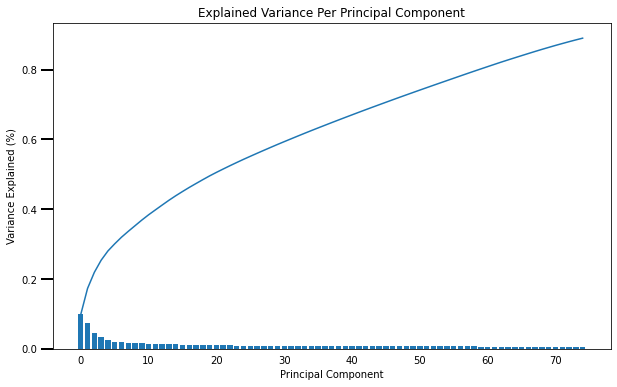

In [48]:
# check ratios
scree_plot(pca=pca)

In [49]:
## check variances to see better where to cut
-np.sort(-pca.explained_variance_ratio_)

array([0.09853869, 0.07447367, 0.04606238, 0.03463733, 0.02655497,
       0.02044461, 0.01896644, 0.01682414, 0.01617238, 0.0161236 ,
       0.0151565 , 0.01399592, 0.01391799, 0.01372069, 0.01291055,
       0.01213906, 0.01180015, 0.01119331, 0.01104586, 0.01076173,
       0.01003892, 0.00965763, 0.00949435, 0.00921252, 0.00902583,
       0.00871861, 0.00863596, 0.00848997, 0.00841015, 0.00831956,
       0.00809579, 0.00802034, 0.00798714, 0.00790925, 0.00779003,
       0.00766589, 0.00760041, 0.00757819, 0.00747164, 0.00742689,
       0.00737398, 0.00734689, 0.00726572, 0.00721   , 0.00713074,
       0.00711145, 0.00710188, 0.00703665, 0.00696411, 0.00690626,
       0.00689534, 0.00685196, 0.00683735, 0.00677141, 0.00675776,
       0.00674763, 0.00674519, 0.00672659, 0.00664645, 0.00657233,
       0.00653977, 0.00652231, 0.00643183, 0.0062546 , 0.00614711,
       0.00609579, 0.00608191, 0.00599963, 0.00586791, 0.00569621,
       0.00564133, 0.00537903, 0.00532165, 0.00512859, 0.00494

In [50]:
## check cumulated sums of variances
np.cumsum(pca.explained_variance_ratio_)

array([0.09853869, 0.17301236, 0.21907474, 0.25371207, 0.28026704,
       0.30071165, 0.31967809, 0.33650223, 0.35267461, 0.36879821,
       0.38395471, 0.39795063, 0.41186862, 0.42558931, 0.43849986,
       0.45063892, 0.46243908, 0.47363239, 0.48467825, 0.49543998,
       0.50547889, 0.51513653, 0.52463088, 0.5338434 , 0.54286923,
       0.55158784, 0.5602238 , 0.56871378, 0.57712393, 0.58544349,
       0.59353928, 0.60155962, 0.60954676, 0.61745601, 0.62524604,
       0.63291193, 0.64051234, 0.64809053, 0.65556217, 0.66298906,
       0.67036305, 0.67770994, 0.68497565, 0.69218565, 0.69931639,
       0.70642784, 0.71352972, 0.72056637, 0.72753049, 0.73443674,
       0.74133208, 0.74818405, 0.75502139, 0.7617928 , 0.76855056,
       0.77529818, 0.78204337, 0.78876996, 0.79541641, 0.80198874,
       0.8085285 , 0.81505082, 0.82148264, 0.82773725, 0.83388435,
       0.83998014, 0.84606205, 0.85206168, 0.85792959, 0.8636258 ,
       0.86926713, 0.87464615, 0.8799678 , 0.88509639, 0.89004

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.

## take 61 components in order to have at least 80% of variance explained
n_components = 61
pca_61 = PCA(n_components)
azdias_pca_61 = pca_61.fit_transform(azdias_ss)

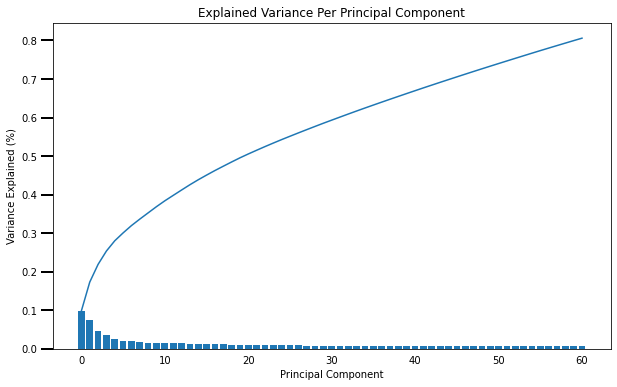

In [52]:
## check ratios again
scree_plot(pca=pca_61)

### Discussion 2.2: Perform Dimensionality Reduction

*My goal was to explain at least 80% of cumulative variance explained by the principal components. First I did a PCA with the number of components half the amount of features. When observing the cumulative sum of the component's variances, I observed it is best to do the cut at the 61st component in order to reach the 80% of cumulative variance explained. So I did the PCA again with n_components=61. With that I will continue the analysis.*

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [92]:
# Map weights for the first, second and third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

## create function 
def map_feature_weights(pca, i_comp, cols):
    weights = pd.DataFrame(pca.components_, columns=cols)
    weights = weights.iloc[i_comp].sort_values(ascending=False)
    return weights

## print out weights of first three components
for i in range(0, 3):
    print('PC ' + str(i) + ':')
    print('-----')
    print(map_feature_weights(pca_61, i, list(azdias_ss.columns)))
    if i != 2:
        print('\n--------------------------------------\n')

PC 0:
-----
LP_STATUS_GROB_1.0    0.200601
HH_EINKOMMEN_SCORE    0.188388
PLZ8_ANTG3            0.183070
WEALTH                0.182442
PLZ8_ANTG4            0.177393
                        ...   
KBA05_GBZ            -0.183697
PLZ8_ANTG1           -0.183791
KBA05_ANTG1          -0.191587
FINANZ_MINIMALIST    -0.200459
MOBI_REGIO           -0.207832
Name: 0, Length: 148, dtype: float64

--------------------------------------

PC 1:
-----
ALTERSKATEGORIE_GROB     0.230231
FINANZ_VORSORGER         0.215792
ZABEOTYP_3               0.201120
SEMIO_ERL                0.180294
SEMIO_LUST               0.162521
                           ...   
SEMIO_TRADV             -0.206638
SEMIO_REL               -0.210564
FINANZ_UNAUFFAELLIGER   -0.212651
FINANZ_SPARER           -0.221251
DECADE                  -0.235717
Name: 1, Length: 148, dtype: float64

--------------------------------------

PC 2:
-----
ANREDE_KZ     0.346653
SEMIO_VERT    0.319859
SEMIO_FAM     0.261398
SEMIO_SOZ     0.257487
S

### Discussion 2.3: Interpret Principal Components

***1st Principal Component:***

*Topics:*
- *low income*
- *family housing in PLZ8*
- *housing in microcell*
- *movement*

*I suspect here it's about people that are in working class with lower incomes living in suburbs where many families live on small space (e.g. in blocks) that come and go.*

***2nd Principal Component:***

*Topics*:
- *age*
- *fair supplied*
- *event-oriented, sensual-minded*
- *financial provision*
- *decade*

*I imagine people in middle class (probably in their thirties) that have many interests and enjoy their lives. They want to be financially secured and care about where their supplies are coming from.*

***3rd Principal Component:***
- *sex*
- *dreamful, family-oriented, socially-minded*
- *combative attitude, dominant, critical*

*Here we are probably talking about women which are dreaming of having a family and children. They fear confrontations and need harmony.*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
## create function to calculate score
def get_kmeans_score(data, center):
    
    ## instantiate model
    kmeans = KMeans(n_clusters=center, random_state=123)
    
    ## fit model to data
    model = kmeans.fit(data)
    
    # Obtain score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [55]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centers = list(range(2, 30, 3))

print('Calculating scores...')
for center in centers:
    score = get_kmeans_score(azdias_pca_61, center)
    scores.append(score)
    print('Center ' + str(center) + ' done with score = ' + str(score))

print('Finished calculations!')

Calculating scores...
Center 2 done with score = 86166262.23942706
Center 5 done with score = 76491156.63926259
Center 8 done with score = 72468871.62686488
Center 11 done with score = 69398844.36751339
Center 14 done with score = 67207491.38167758
Center 17 done with score = 65516669.54735234
Center 20 done with score = 64046466.25329532
Center 23 done with score = 62317943.283373736
Center 26 done with score = 61035096.607923575
Center 29 done with score = 59576099.41366196
Finished calculations!


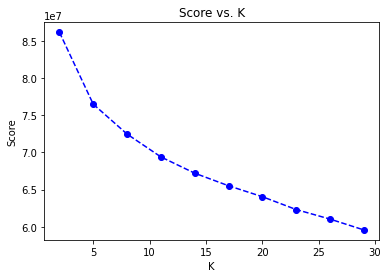

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. K');

In [57]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

## Choose 14 clusters since after the curve becomes slightly flatter
n_center = 14

## instantiate model
k_means = KMeans(n_clusters=n_center, random_state=123)

## fit model to data
model = k_means.fit(azdias_pca_61)

## predict labels on same data to show category that point belongs to
pred = model.predict(azdias_pca_61)

In [58]:
## check cluster sizes
clust_amount = np.bincount(pred)
clust_number = np.nonzero(clust_amount)[0]
np.vstack((clust_number,clust_amount[clust_number])).T

array([[     0,  59595],
       [     1,  57551],
       [     2,  77441],
       [     3,  34181],
       [     4,  48073],
       [     5,  48998],
       [     6,  45803],
       [     7,  46880],
       [     8,  79003],
       [     9,  45089],
       [    10,  85422],
       [    11, 103826],
       [    12,  26909],
       [    13,  38306]], dtype=int64)

### Discussion 3.1: Apply Clustering to General Population

*I have decided to segment the population into 14 clusters. This decision is based on the plot "Score vs. K". There we can see that after 14 clusters the average difference from each point to its assigned cluster's center is flatting out a bit (almost a linear line).*

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.describe()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,191652.000000,191652.000000,145056.000000,145056.000000,145056.000000,188684.000000,79715.000000,137910.000000,145056.000000,141725.000000,139542.000000,141725.000000,145001.000000,141725.000000,141725.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,141693.000000,141693.000000,141693.000000,141725.000000,137392.000000,135672.000000,188439.000000,137392.000000,140371.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,4.137958,1003.392733,6.302268,0.367171,1.198396,18.181571,5.422694,4.254448,2.355043,6.687910,3.209251,0.773433,4.248273,3.716311,3.742137,4.414026,4.112788,3.883163,4.185279,5.366477,4.408021,3.682497,3.165879,4.674535,4.483835,4.187246,3.528254,2.919161,0.987754,0.009865,0.021681,0.849008,2.576806,11.352009,2.267828,0.020392,2.942481,3.421803,4.152716,8.646371,4.965863,0.067413,2.369942,3.129978,1993.056659,3.723133,2.207058,1.209004,0.309968,0.153385,1.043826,3.630403,4.301758,3.881702,4.784577,3.852524,2.321569,3.627425,2.764327,3.814341,667.231216,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,1.503946,974.531081,2.877181,0.482035,1.450937,15.009985,4.717907,4.492807,2.052142,3.090573,1.436958,0.495983,3.807671,1.113933,1.718039,1.733128,2.070958,1.840131,2.367407,1.443103,1.720909,1.573090,1.316221,2.041059,1.631941,1.872047,1.493916,1.219224,1.538679,0.098833,0.210424,1.166162,1.168486,6.275026,1.390620,0.152234,1.533347,1.623890,1.974375,1.154001,14.309694,0.545576,2.434227,1.439740,3.080241,2.095540,1.383509,1.086202,0.765292,0.476992,1.384973,1.168496,2.114614,1.607621,1.961473,0.830285,1.100512,1.282444,1.266050,2.075155,340.481722,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
pd.set_option('display.max_columns', None)
customers_clean = clean_data(customers)
print(customers_clean.shape)
customers_clean.head()

Missing value codes are converted to NaN.
Removed columns with share of missings of more than 30%.
Removed rows with share of missings of more than 20%.


C:\Users\rutis\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\rutis\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Re-encoding done.
Imputation done.
(141590, 147)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0
1,4.0,0.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0,9.0,1.0,0.0,2.0,1992.0,0.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [70]:
## customers dataset has fewer number of features, so
## add them to the dataset with value 0
add_cols = list(set(azdias.columns) - set(customers_clean.columns))
print(add_cols)

for i in add_cols:
    customers_clean[i] = 0.0

print(customers_clean.shape)
customers_clean.head()

['GEBAEUDETYP_5.0']
(141590, 148)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,0.0
1,4.0,0.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0,9.0,1.0,0.0,2.0,1992.0,0.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [71]:
## do feature scaling using StandardScaler from sklearn
customers_ss = StandardScaler().fit_transform(customers_clean)
customers_ss = pd.DataFrame(customers_ss, columns=customers_clean.columns)
customers_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,0.701672,0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,-0.553522,1.006178,-1.256561,0.921687,1.032369,0.657199,-0.813797,1.267701,0.457658,0.907212,-1.067925,0.049224,-1.348432,-0.514128,-1.884931,-1.448488,-0.719540,-1.369748,-0.099571,-0.971258,-0.194486,-0.133787,-1.361858,0.919606,0.304866,-0.278287,-0.12263,1.292272,-0.342936,-0.294966,-0.146438,0.751580,-0.395127,-0.314098,0.308972,-0.615754,-1.170621,-0.400174,0.177479,-1.425514,0.283885,0.018704,-1.582585,1.576681,0.505044,0.315897,-0.434313,-0.833723,1.482836,1.370406,-1.810981,-1.447355,-1.338848,-0.436592,-0.632726,-0.439237,-0.464659,2.698887,-0.278786,-0.170812,1.541641,-0.180907,-0.113889,-0.701589,-0.656438,-0.249221,-0.184887,-0.329093,2.859940,-0.358387,-0.211072,-0.318643,-0.363337,-0.194478,-0.469057,-0.228468,-0.225197,-0.612226,2.044967,-0.031684,-0.060713,-0.076836,-0.073994,-0.141388,-0.179129,-0.12736,-0.560052,-0.415647,-0.612226,2.044967,-0.103232,-0.243869,-0.819973,-0.382008,-0.095663,-0.332037,-0.185315,-0.079263,-0.211437,-0.271149,-0.073994,-0.533950,1.320764,-0.397446,-0.401369,-0.353854,-0.542364,1.320764,0.165302,-0.130109,-0.100256,-0.518784,-0.593202,-0.442745,1.370452,-0.788569,-0.225958,1.173213,-0.339926,-0.083184,-0.195337,0.699528,-0.120394,-0.447687,-0.041973,-0.03146,-0.411092,2.727735,-0.44581,-0.386149,-0.429462,-0.299427,-0.39016,-0.283786,-0.318482,-0.217312,0.988344,-0.663061,-1.138071,-0.277125,0.0
1,0.701672,-1.42288,0.723000,-0.516937,0.516188,-0.600675,2.183668,0.965412,1.006178,0.048108,0.921687,-1.438336,-1.125456,-1.498963,-0.245631,-1.246345,0.907212,1.215417,-1.662390,-0.634477,1.734865,0.627890,1.339292,0.677268,-1.369748,-0.099571,1.029592,-0.913436,-0.133787,-1.361858,0.91

In [73]:
## take the pca_61 object from above and transform
customers_pca_61 = pca_61.transform(customers_ss)

## predict labels on same data to show category that point belongs to
customers_pred = model.predict(customers_pca_61)

In [74]:
## check cluster sizes
clust_amount = np.bincount(customers_pred)
clust_number = np.nonzero(clust_amount)[0]
np.vstack((clust_number,clust_amount[clust_number])).T

array([[    0,  3467],
       [    1,  6487],
       [    2, 14244],
       [    3, 10182],
       [    4,  8373],
       [    5, 10573],
       [    6,  9317],
       [    7,  7056],
       [    8,  3544],
       [    9, 10671],
       [   10, 25842],
       [   11, 23295],
       [   12,  1493],
       [   13,  7046]], dtype=int64)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

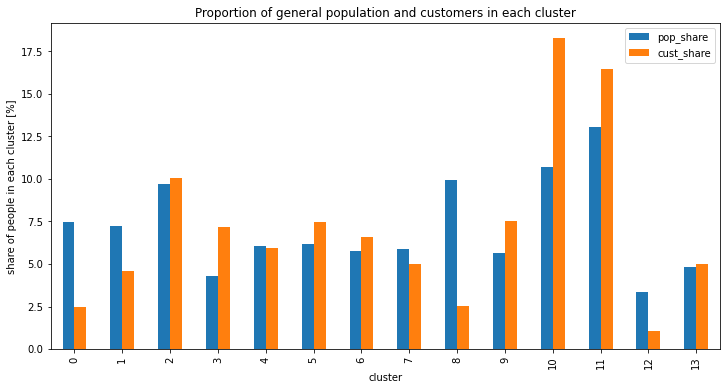

In [91]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop_share = []
cust_share = []

## calculate proportions
for i in range(n_center):
    pop_share.append((pred == i).sum() / len(pred) * 100)
    cust_share.append((customers_pred == i).sum() / len(customers_pred) * 100)

## create dict with shares
pop_cust = pd.DataFrame({'cluster': list(range(0, n_center)),
                         'pop_share': pop_share, 
                         'cust_share': cust_share})

## plot
pop_cust.plot(x = 'cluster', 
              y = ['pop_share', 'cust_share'], 
              kind = 'bar', 
              figsize=(12,6))
plt.title('Proportion of general population and customers in each cluster')
plt.ylabel('share of people in each cluster [%]')
plt.show()

In [103]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

## filter cluster 10 from customer data which is overrepresented compared to general population
clust_over = customers_clean.iloc[np.where(customers_pred == 10)]
print(clust_over.shape)
clust_over.head()

(25842, 148)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,0.0
5,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,5.0,4.0,2.0,5.0,1.0,6.0,5.0,3.0,4.0,3.0,3.0,1.0,2.0,2.0,4.0,0.0,0.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1992.0,0.0,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,5.0,5.0,2.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0
6,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,4.0,5.0,6.0,7.0,7.0,3.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,3.0,1992.0,0.0,3.0,2.0,0.0,0.0,4.0,5.0,3.0,5.0,4.0,1.0,4.0,3.0,1.0,481.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.

In [104]:
print(map_feature_weights(pca_61, 10, list(customers_ss.columns)))

KBA05_ANTG4             0.200700
LP_FAMILIE_GROB_4.0     0.188374
NATIONALITAET_KZ_1.0    0.177108
ANZ_HAUSHALTE_AKTIV     0.166163
LP_STATUS_FEIN_2.0      0.151667
                          ...   
NATIONALITAET_KZ_2.0   -0.155614
SEMIO_RAT              -0.155670
SEMIO_MAT              -0.163163
ZABEOTYP_6             -0.169021
KBA05_ANTG2            -0.198207
Name: 10, Length: 148, dtype: float64


In [133]:
## check counts of heavy weighted features
clust_over['LP_FAMILIE_GROB_4.0'].value_counts()

0.0    25842
Name: LP_FAMILIE_GROB_4.0, dtype: int64

Notes cluster 10:
- no 10+ family homes
- no family
- german-sounding name
- not indifferent energy consumption
- very materialistic

In [115]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

## filter cluster 8 from customer data which is overrepresented compared to general population
clust_under = customers_clean.iloc[np.where(customers_pred == 8)]
print(clust_under.shape)
clust_under.head()

(3544, 148)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
54,3.0,0.0,3.0,2.0,4.0,2.0,3.0,2.0,0.0,2.0,2.0,4.0,1.0,3.0,2.0,4.0,6.0,6.0,3.0,4.0,6.0,6.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,5.0,4.0,9.0,6.0,0.0,4.0,1994.0,0.0,2.0,2.0,0.0,0.0,5.0,2.0,5.0,4.0,5.0,2.0,3.0,5.0,2.0,1500.0,2.0,3.0,1.0,0.0,5.0,5.0,3.0,5.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0
71,3.0,0.0,2.0,2.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,2.0,1.0,1.0,3.0,4.0,1.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,5.0,4.0,3.0,5.0,0.0,3.0,1990.0,0.0,0.0,3.0,1.0,0.0,3.0,6.0,5.0,7.0,3.0,1.0,2.0,3.0,1.0,634.0,2.0,3.0,2.0,1.0,4.0,4.0,3.0,6.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,4.0,0.0
76,3.0,0.0,2.0,2.0,4.0,3.0,3.0,3.0,0.0,3.0,5.0,5.0,3.0,3.0,5.0,2.0,4.0,6.0,3.0,4.0,4.0,7.0,7.0,1.0,3.0,0.0,0.0,2.0,0.0,5.0,3.0,9.0,7.0,0.0,2.0,1992.0,0.0,1.0,2.0,1.0,0.0,3.0,7.0,5.0,2.0,4.0,2.0,2.0,4.0,2.0,549.0,2.0,3.0,2.0,1.0,4.0,4.0,3.0,7.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [116]:
print(map_feature_weights(pca_61, 8, list(customers_ss.columns)))

LP_FAMILIE_FEIN_2.0     0.415806
LP_FAMILIE_GROB_2.0     0.415806
OST_WEST_KZ             0.238441
W_KEIT_KIND_HH          0.141408
ARBEIT                  0.140882
                          ...   
LP_FAMILIE_FEIN_10.0   -0.131929
LP_FAMILIE_GROB_5.0    -0.179063
PLZ8_GBZ               -0.253749
PLZ8_HHZ               -0.311170
KBA13_ANZAHL_PKW       -0.323594
Name: 8, Length: 148, dtype: float64


In [132]:
## check counts of heavy weighted features
clust_over['LP_FAMILIE_FEIN_2.0'].value_counts()

0.0    18941
1.0     6901
Name: LP_FAMILIE_FEIN_2.0, dtype: int64

Notes cluster 8:
- no couples
- west germany
- no children in household
- average share of unemployment in community
- have high number of cars in PLZ
- have 300-599 households within PLZ
- area with more than 130 buildings

### Discussion 3.3: Compare Customer Data to Demographics Data

*Cluster 10 contains people for which the mail-order company is very popular. They are not having family, seem to be of German origin and are very materialistic.*

*On the other hand, cluster 8 contains people that are relatively unpopular with the mail-order company. They tend to be single West Germans that are living in rather big cities.*

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.